In [2]:
from apps.advection import advection
from apps.advection.riemannsystemexample import riemann_system_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

from IPython.display import HTML

# Riemann System Advection Example

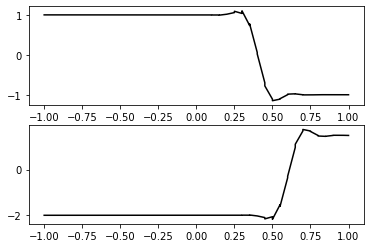

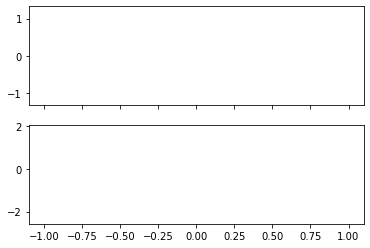

In [6]:
wavespeed = 1.0
left_states = [1.0, -2.0]
right_states = [-1.0, 1.5]
discontinuity_locations = [-0.6, -0.4]
time_final = 1.0
problem = riemann_system_example.RiemannSystemExample(wavespeed, left_states, right_states, discontinuity_locations)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["order"] = 2

num_elems = 40
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = -1.0
problem.parameters["mesh"]["x_right"] = 1.0
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = 2

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = 0.3
problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, 2.0 / num_elems)

final_solution = main.run(problem)
p = plot.create_plot_dg(final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

# Convergence Test

## DG Convergence

In [7]:
wavespeed = 1.0
left_states = [1.0, -2.0]
right_states = [-1.0, 1.5]
discontinuity_locations = [-0.6, -0.4]
problem = riemann_system_example.RiemannSystemExample(wavespeed, left_states, right_states, discontinuity_locations)
time_final = 1.0
exact_solution = problem.exact_solution
exact_final_solution = x_functions.FrozenT(exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [8]:
for num_basis_cpts in range(1,2):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = dg_utils.standard_cfls(num_basis_cpts)
    error_list = []
    for num_elems in [20, 40]:
        problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, (x_right - x_left) / num_elems)
        problem.parameters["mesh"]["num_elems"] = num_elems
        final_solution = main.run(problem)
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

-1.0
[1.6212677718685768e-15, 3.3478105400812016e-15]


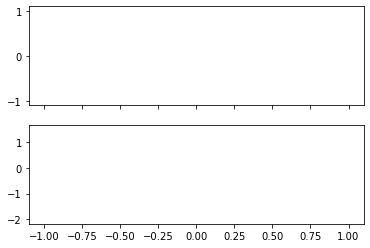

In [9]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

## FV Convergence

In [10]:
wavespeed = 1.0
left_states = [1.0, -2.0]
right_states = [-1.0, 1.5]
discontinuity_locations = [-0.6, -0.4]
problem = riemann_system_example.RiemannSystemExample(wavespeed, left_states, right_states, discontinuity_locations)
time_final = 1.0
exact_solution = problem.exact_solution
exact_final_solution = x_functions.FrozenT(exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True
problem.parameters["use_wave_propogation_method"] = True

problem.parameters["basis"]["basis_class"] = "finite_volume"

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["order"] = 1
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "exact_linear"

In [11]:
cfl = dg_utils.standard_cfls(1)
error_list = []
for num_elems in [20, 40]:
    problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, (x_right - x_left) / num_elems)
    problem.parameters["mesh"]["num_elems"] = num_elems
    final_solution = main.run(problem)
    error = math_utils.compute_error(final_solution, exact_final_solution)
    error_list.append(error)
order = utils.convergence_order(error_list)
if error_list[-1] >= math_utils.MACHINE_ERROR:
    assert order >= 1
else:
    # This should in fact be exact, only machine error as exactly solving riemann problem
    print(error_list)

[8.301764843409893e-17, 1.2747176248828981e-15]


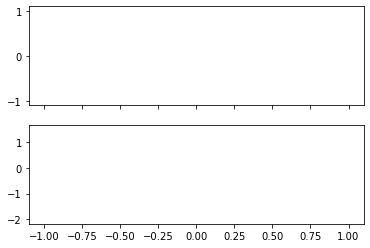

In [12]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())